                    Supervised Learning Capstone Slide Deck

In this capstone, I will be using the Titanic dataset to predit survived using the keyfeatures presented in the data set. 
I will go through data cleaning, feature selection/elimination/combination and then use some of the models learned in the class modules to see which model yields good results.
Also I will be tuning some of the hyperparamters for few models to see which one does the best job.


In [1]:
#Import libraries :
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Using Titanic dataset from Kaggle hosted on github so shared notebook can be run:

train_df = pd.read_csv('https://raw.githubusercontent.com/pcsanwald/kaggle-titanic/master/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/pcsanwald/kaggle-titanic/master/test.csv')
combine = [train_df, test_df]

print(train_df.columns.values)
print(test_df.columns.values)

# preview the data
train_df.head()
train_df.tail()
train_df.info()
print('_'*40)
test_df.info()
train_df.describe()


['survived' 'pclass' 'name' 'sex' 'age' 'sibsp' 'parch' 'ticket' 'fare'
 'cabin' 'embarked']
['pclass' 'name' 'sex' 'age' 'sibsp' 'parch' 'ticket' 'fare' 'cabin'
 'embarked']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
ticket      891 non-null object
fare        891 non-null float64
cabin       204 non-null object
embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
pclass      418 non-null int64
name        418 non-null object
sex         418 non-null object
age         332 non-null float64
sibsp       418 non-null int64
pa

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


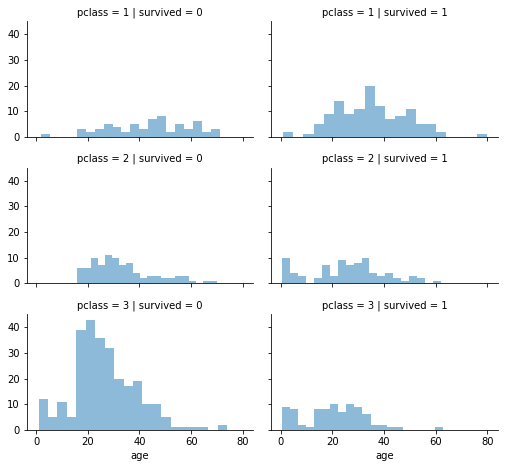

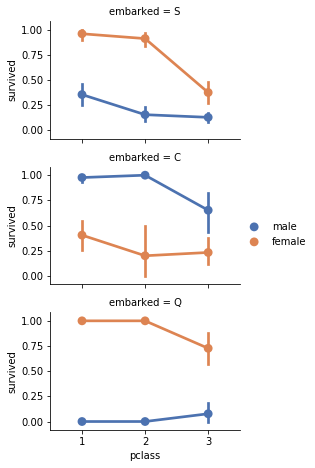

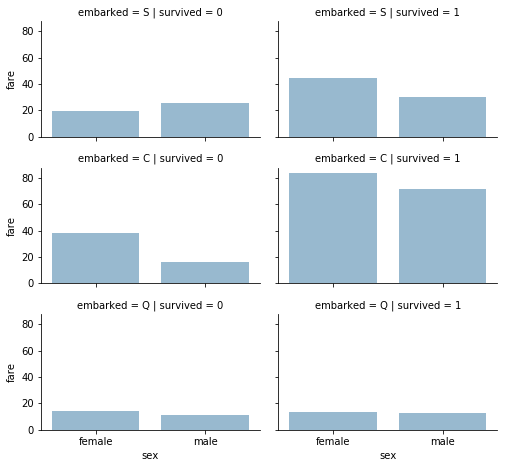

In [3]:
#Visualizing data and Correlating numerical features
grid = sns.FacetGrid(train_df, col='survived', row='pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();
#print(train_df.columns.values)

#Correlating categorical features, add Sex and Embarked features
grid = sns.FacetGrid(train_df, row='embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'pclass', 'survived', 'sex', palette='deep')
grid.add_legend()
#print(train_df.columns.values)

#Correlating categorical and numerical features
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='embarked', col='survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'sex', 'fare', alpha=.5, ci=None)
grid.add_legend()
#print(train_df.columns.values)

In [4]:
#Data Cleaning, data dummy, and feature engineering, 

#Dropping unsignificant features
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
train_df = train_df.drop(['ticket', 'cabin'], axis=1)
test_df = test_df.drop(['ticket', 'cabin'], axis=1)
combine = [train_df, test_df]

print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
print(train_df.columns.values)

#Creating new feature extracting from existing
for dataset in combine:
    dataset['Title'] = dataset.name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['sex'])

#Replace many titles with a more common name or classify them as Rare
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'survived']].groupby(['Title'], as_index=False).mean()

#Converting and fillin data:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

#Also drop Name and passengerid features from training and testing datasets. 
train_df = train_df.drop(['name'], axis=1)
test_df = test_df.drop(['name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

#Dummy sex column:
for dataset in combine:
   dataset['sex'] = dataset['sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

Before (891, 11) (418, 10) (891, 11) (418, 10)
After (891, 9) (418, 8) (891, 9) (418, 8)
['survived' 'pclass' 'name' 'sex' 'age' 'sibsp' 'parch' 'fare' 'embarked']


,survived,pclass,sex,age,sibsp,parch,fare,embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [5]:
#Continue data/feature work:
#Guess missing age data based on Pclass x Gender combinations.
guess_ages = np.zeros((2,3))
guess_ages
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['sex'] == i) & \
                                  (dataset['pclass'] == j+1)]['age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.age.isnull()) & (dataset.sex == i) & (dataset.pclass == j+1),\
                    'age'] = guess_ages[i,j]

    dataset['age'] = dataset['age'].astype(int)

train_df.head()

#create Age bands and determine correlations with Survived
train_df['AgeBand'] = pd.cut(train_df['age'], 5)
train_df[['AgeBand', 'survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

#replace Age based on AgeBand.
for dataset in combine:    
    dataset.loc[ dataset['age'] <= 16, 'age'] = 0
    dataset.loc[(dataset['age'] > 16) & (dataset['age'] <= 32), 'age'] = 1
    dataset.loc[(dataset['age'] > 32) & (dataset['age'] <= 48), 'age'] = 2
    dataset.loc[(dataset['age'] > 48) & (dataset['age'] <= 64), 'age'] = 3
    dataset.loc[ dataset['age'] > 64, 'age']
train_df.head()

#We can now remove the AgeBand feature.
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

#Create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.
for dataset in combine:
    dataset['FamilySize'] = dataset['sibsp'] + dataset['parch'] + 1

train_df[['FamilySize', 'survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='survived', ascending=False)

#create another feature called IsAlone
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'survived']].groupby(['IsAlone'], as_index=False).mean()

#drop Parch, SibSp, and FamilySize features in favor of IsAlone.
train_df = train_df.drop(['parch', 'sibsp', 'FamilySize'], axis=1)
test_df = test_df.drop(['parch', 'sibsp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

#create an artificial feature combining Pclass and Age
for dataset in combine:
    dataset['age*class'] = dataset.age * dataset.pclass

train_df.loc[:, ['age*class', 'age', 'pclass']].head(10)

#Embarked feature takes S, Q, C values based on port of embarkation. 
freq_port = train_df.embarked.dropna().mode()[0]
freq_port

for dataset in combine:
    dataset['embarked'] = dataset['embarked'].fillna(freq_port)
    
train_df[['embarked', 'survived']].groupby(['embarked'], as_index=False).mean().sort_values(by='survived', ascending=False)

#Convert the EmbarkedFill feature by creating a new numeric Port feature
for dataset in combine:
    dataset['embarked'] = dataset['embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

#Round off the fare to two decimals as it represents currency
test_df['fare'].fillna(test_df['fare'].dropna().median(), inplace=True)
test_df.head()

#We can now create FareBand.
train_df['FareBand'] = pd.qcut(train_df['fare'], 4)
train_df[['FareBand', 'survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

#Convert the Fare feature to ordinal values based on the FareBand
for dataset in combine:
    dataset.loc[ dataset['fare'] <= 7.91, 'fare'] = 0
    dataset.loc[(dataset['fare'] > 7.91) & (dataset['fare'] <= 14.454), 'fare'] = 1
    dataset.loc[(dataset['fare'] > 14.454) & (dataset['fare'] <= 31), 'fare']   = 2
    dataset.loc[ dataset['fare'] > 31, 'fare'] = 3
    dataset['fare'] = dataset['fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,survived,pclass,sex,age,fare,embarked,Title,IsAlone,age*class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [6]:
#Exam the test dataset.
test_df.head(10)

#To identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...) and train our model with a given dataset:
#Logistic Regression
#KNN
#Support Vector Machines
#Decision Tree
#Random Forrest


X_train = train_df.drop("survived", axis=1)
Y_train = train_df["survived"]
X_test  = test_df.copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [7]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,sex,2.201527
5,Title,0.398234
2,age,0.287163
4,embarked,0.261762
6,IsAlone,0.129140
3,fare,-0.085150
7,age*class,-0.311200
0,pclass,-0.749007


In [8]:
#KNN confidence score is better than Logistics Regression but worse than SVM
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(acc_knn)

#Tune KNN model by changing the n_neighbors value:
knn5 = KNeighborsClassifier(n_neighbors = 5)
knn5.fit(X_train, Y_train)
Y_pred = knn5.predict(X_test)
acc_knn5 = round(knn5.score(X_train, Y_train) * 100, 2)
print(acc_knn5)

84.74
83.95


Turns out in this case, increase n_neighbor value did not optimized the model.

In [9]:
#What about decrease the value of n_neighbor?
knn2 = KNeighborsClassifier(n_neighbors = 2)
knn2.fit(X_train, Y_train)
Y_pred = knn2.predict(X_test)
acc_knn2 = round(knn2.score(X_train, Y_train) * 100, 2)
print(acc_knn2)

83.84


So seems the first choice of n_neighbors = 3 is the best value for this model

In [10]:
#Compare SVC linear kernel vs LinearSVC functions:

# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print(acc_linear_svc)

# Support Vector Machines
svclinear = SVC(kernel='linear')
svclinear.fit(X_train, Y_train)
Y_pred = svclinear.predict(X_test)
acc_svclinear = round(svclinear.score(X_train, Y_train) * 100, 2)
print(acc_svclinear)

#Tuning the SVC model using RBF kernel:
svcrbf = SVC(kernel='rbf', random_state=0, gamma=1, C=1)
svcrbf.fit(X_train, Y_train)
Y_pred = svcrbf.predict(X_test)
acc_svcrbf = round(svcrbf.score(X_train, Y_train) * 100, 2)
print(acc_svcrbf)

78.56
78.68
86.76


Seems Using the RBF kernel yield a better model

In [11]:
# Decision Tree
import time
start = time.time()

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(acc_decision_tree)

#print(f'Decision Tree runtime elapsed: {round(time.time() - start, 2)} seconds.')

#Turn the model by set the max_depth to 3:
decision_tree3 = DecisionTreeClassifier(max_depth=3)
decision_tree3.fit(X_train, Y_train)
Y_pred = decision_tree3.predict(X_test)
acc_decision_tree3 = round(decision_tree3.score(X_train, Y_train) * 100, 2)
print(acc_decision_tree3)

86.76
81.26


#Seems the default one yield a better result.

In [12]:
# Random Forest

start = time.time()

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

print(f'Decision Tree runtime elapsed: {round(time.time() - start, 2)} seconds.')

Decision Tree runtime elapsed: 0.17 seconds.


In [13]:
#Model Evaluation:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Decision Tree'],
    'Score': [acc_svcrbf, acc_knn, acc_log, 
              acc_random_forest, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,86.76
3,Random Forest,86.76
4,Decision Tree,86.76
1,KNN,84.74
2,Logistic Regression,80.36


Looks line Random Forest and Decision Tree models performed equally well.